In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from utils import setup_plotting_standards

setup_plotting_standards()
COLOR = '#343434'

# Figure 2C: Antimicrobial resistance profile over time
Here we determined whether the AMR profile of cholera changed over the course of our surveillance period. We profiled each sample for the presence or absense of known antimicrobial resistance markers using [AMRFinderPlus](https://www.ncbi.nlm.nih.gov/pathogens/antimicrobial-resistance/AMRFinder/).

First, we load the metadata for the CholGEN sequences, and extract the columns corresponding to AMR results. We remove catB9 and varG because they are no longer associated with chloramphenicol and carbapenem resistance in _Vibrio cholerae_ [[1]](https://doi.org/10.1046/j.1365-2958.2002.02861.x)[[2]](https://doi.org/10.3389/fpubh.2016.00231).

In [2]:
md = pd.read_csv( "../data/supplemental_data1.csv", parse_dates=["collection_date"] )
md = md.loc[md["included_analysis"]].copy()

amr_columns = [col for col in md.columns if col.startswith( "core_gene")]

# See note above, no longer associated with AMR.
amr_columns.remove( "core_gene_catB9" )
amr_columns.remove( "core_gene_varG" )

amr_core_genes = md[["taxa", "collection_date", "country"] + amr_columns].copy()
amr_core_genes["month"] = amr_core_genes["collection_date"].to_numpy().astype('datetime64[M]')
amr_core_genes["year"] = amr_core_genes["collection_date"].dt.year

md.head()

,taxa,alt_taxa_ID,original_name,accession,collection_date,collection_year,continent,country,iso3,admin1,...,core_gene_qnrD1,core_gene_mph(E),core_gene_msr(E),core_gene_blaPER-7,core_gene_sul1,core_gene_aadA2,core_gene_blaDHA,core_gene_qnrD2,core_gene_blaDHA-20,core_gene_qnrD3
0,Africa|COD|DC-0106109|T10|2022-10-25,DRC-0106,DC-0106109,SAMN43792774,2022-10-25,2022.0,Africa,Democratic Republic of the Congo,COD,Nord-Kivu,...,False,False,False,False,False,False,False,False,False,False
1,Africa|COD|DC-188126|T10|2023-01-05,DRC-188,DC-188126,SAMN43792775,2023-01-05,2023.0,Africa,Democratic Republic of the Congo,COD,Nord-Kivu,...,False,False,False,False,False,False,False,False,False,False
2,Africa|COD|DC-295115|T10|2023-01-06,DRC-295,DC-295115,SAMN43792776,2023-01-06,2023.0,Africa,Democratic Republic of the Congo,COD,Nord-Kivu,...,False,False,False,False,False,False,False,False,False,False
3,Africa|COD|DC-101125|T10|2022-01-01,DRC-101,DC-101125,SAMN43792777,2022-10-24,2022.0,Africa,Democratic Republic of the Congo,COD,Nord-Kivu,...,False,False,False,False,False,False,False,False,False,False
4,Africa|COD|DC-0067116|T10|2023-01-02,DRC-0067,DC-0067116,SAMN43792778,2023-01-02,2023.0,Africa,Democratic Republic of the Congo,COD,Nord-Kivu,...,False,False,False,False,False,False,False,False,False,False


We calculate the fraction of sequences in each country and year that contain evidence of AMR.

In [3]:
amr_long = amr_core_genes.melt( id_vars=["taxa", "country", "month"], value_vars=amr_columns, var_name="gene", value_name="present" )
amr_long = amr_long.groupby( ["country", "month", "gene"] ).agg( total=("present", "count"), present=("present", "sum")).reset_index()
amr_long["absent"] = amr_long["total"] - amr_long["present"]
amr_long["absent"] /= amr_long["total"]
amr_long["present"] /= amr_long["total"]
amr_long["gene"] = amr_long["gene"].str.replace( "core_gene_", "" )

amr_long.head()

,country,month,gene,total,present,absent
0,Cameroon,2020-02-01,aac(3)-IIe,3,0.0,1.0
1,Cameroon,2020-02-01,aadA2,3,0.0,1.0
2,Cameroon,2020-02-01,almE,3,0.666667,0.333333
3,Cameroon,2020-02-01,almF,3,0.666667,0.333333
4,Cameroon,2020-02-01,almG,3,0.666667,0.333333


We load in a summary of the reference gene catalog used by AMRFinderPlus. This is present in the data directory but you can find an updated version [here](https://www.ncbi.nlm.nih.gov/pathogens/refgene/#). Specifically, we're interested in the antibiotic class that an AMR allele provides resistance against.

In [4]:
resistances = pd.read_csv( "../data/amr_refgenes.csv" )
resistances.loc[resistances["#Allele"].isna(),"#Allele"] = resistances["Gene family"]
resistances.head()

,#Allele,Gene family,Product name,Scope,Type,Subtype,Class,Subclass,RefSeq protein,RefSeq nucleotide,GenBank protein,GenBank nucleotide,Curated RefSeq start,Links
0,16S_A1055G,16S,16S ribosomal RNA,core,AMR,POINT,TETRACYCLINE,TETRACYCLINE,NaN,NC_000913.3,NaN,U00096.3,NaN,0
1,16S_A1408G,16S,16S ribosomal RNA,core,AMR,POINT,AMINOGLYCOSIDE,GENTAMICIN C/NEOMYCIN/PAROMOMYCIN,NaN,NC_000913.3,NaN,U00096.3,NaN,0
2,16S_A1499G,16S,16S ribosomal RNA,core,AMR,POINT,EDEINE,EDEINE,NaN,NC_000913.3,NaN,U00096.3,NaN,0
3,16S_A1519C,16S,16S ribosomal RNA,core,AMR,POINT,AMINOGLYCOSIDE,KASUGAMYCIN,NaN,NC_000913.3,NaN,U00096.3,NaN,0
4,16S_A1519G,16S,16S ribosomal RNA,core,AMR,POINT,AMINOGLYCOSIDE,KASUGAMYCIN,NaN,NC_000913.3,NaN,U00096.3,NaN,0


We match the antibiotic class to the alleles present in our data.

In [5]:
gene_resistances = resistances.loc[resistances["#Allele"].isin( amr_long["gene"].unique() )].groupby( "#Allele").last().reset_index()
gene_resistances = gene_resistances[["#Allele", "Gene family", "Class", "Subclass"]]
gene_resistances["Class"] = gene_resistances["Class"].apply( lambda x: x.split( "/" )[0] )
gene_resistances = gene_resistances.sort_values( ["Class", "#Allele"])
gene_order = gene_resistances["#Allele"].to_list()
gene_names = gene_resistances["Gene family"].to_list()
gene_resistances

,#Allele,Gene family,Class,Subclass
0,aac(3)-IIe,aac(3)-IIe,AMINOGLYCOSIDE,GENTAMICIN
1,aadA2,aadA2,AMINOGLYCOSIDE,STREPTOMYCIN
5,aph(6)-Id,aph(6)-Id,AMINOGLYCOSIDE,STREPTOMYCIN
6,blaCTX-M-55,blaCTX-M,BETA-LACTAM,CEPHALOSPORIN
7,blaDHA-20,blaDHA,BETA-LACTAM,CEPHALOSPORIN
8,blaPER-7,blaPER,BETA-LACTAM,CEPHALOSPORIN
2,almE,almE,COLISTIN,COLISTIN
3,almF,almF,COLISTIN,COLISTIN
4,almG,almG,COLISTIN,COLISTIN
12,mph(A),mph(A),MACROLIDE,AZITHROMYCIN/ERYTHROMYCIN/SPIRAMYCIN/TELITHROM...


Here we prepare the discontinuous axis for the plot.

In [6]:
country_dates = dict()
country_date_str = dict()
date_format = "%b"
secondary_format = "%b %Y"

for country, entry in amr_long.loc[amr_long["gene"]=="aac(3)-IIe"].groupby( "country" ):
    prior_date = None
    date_order = list()
    date_str = list()
    years_observed = list()
    for date in entry["month"]:
        if prior_date is None:
            prior_date = date
        duration = date - prior_date
        date_order.append( (date, "line" if duration >= pd.Timedelta( days=80 ) else "normal" ) )
        if date.strftime( "%Y" ) not in years_observed:
            date_str.append( date.strftime( secondary_format ) )
            years_observed.append( date.strftime( "%Y" ) )
        else: 
            date_str.append( date.strftime( date_format ) )
        prior_date = date
    country_dates[country] = date_order
    country_date_str[country] = date_str

We plot the fraction of samples collected in a given month and country that have evidence of a given AMR allele stratified by the antibiotic class. This generates supplemental figure 2.

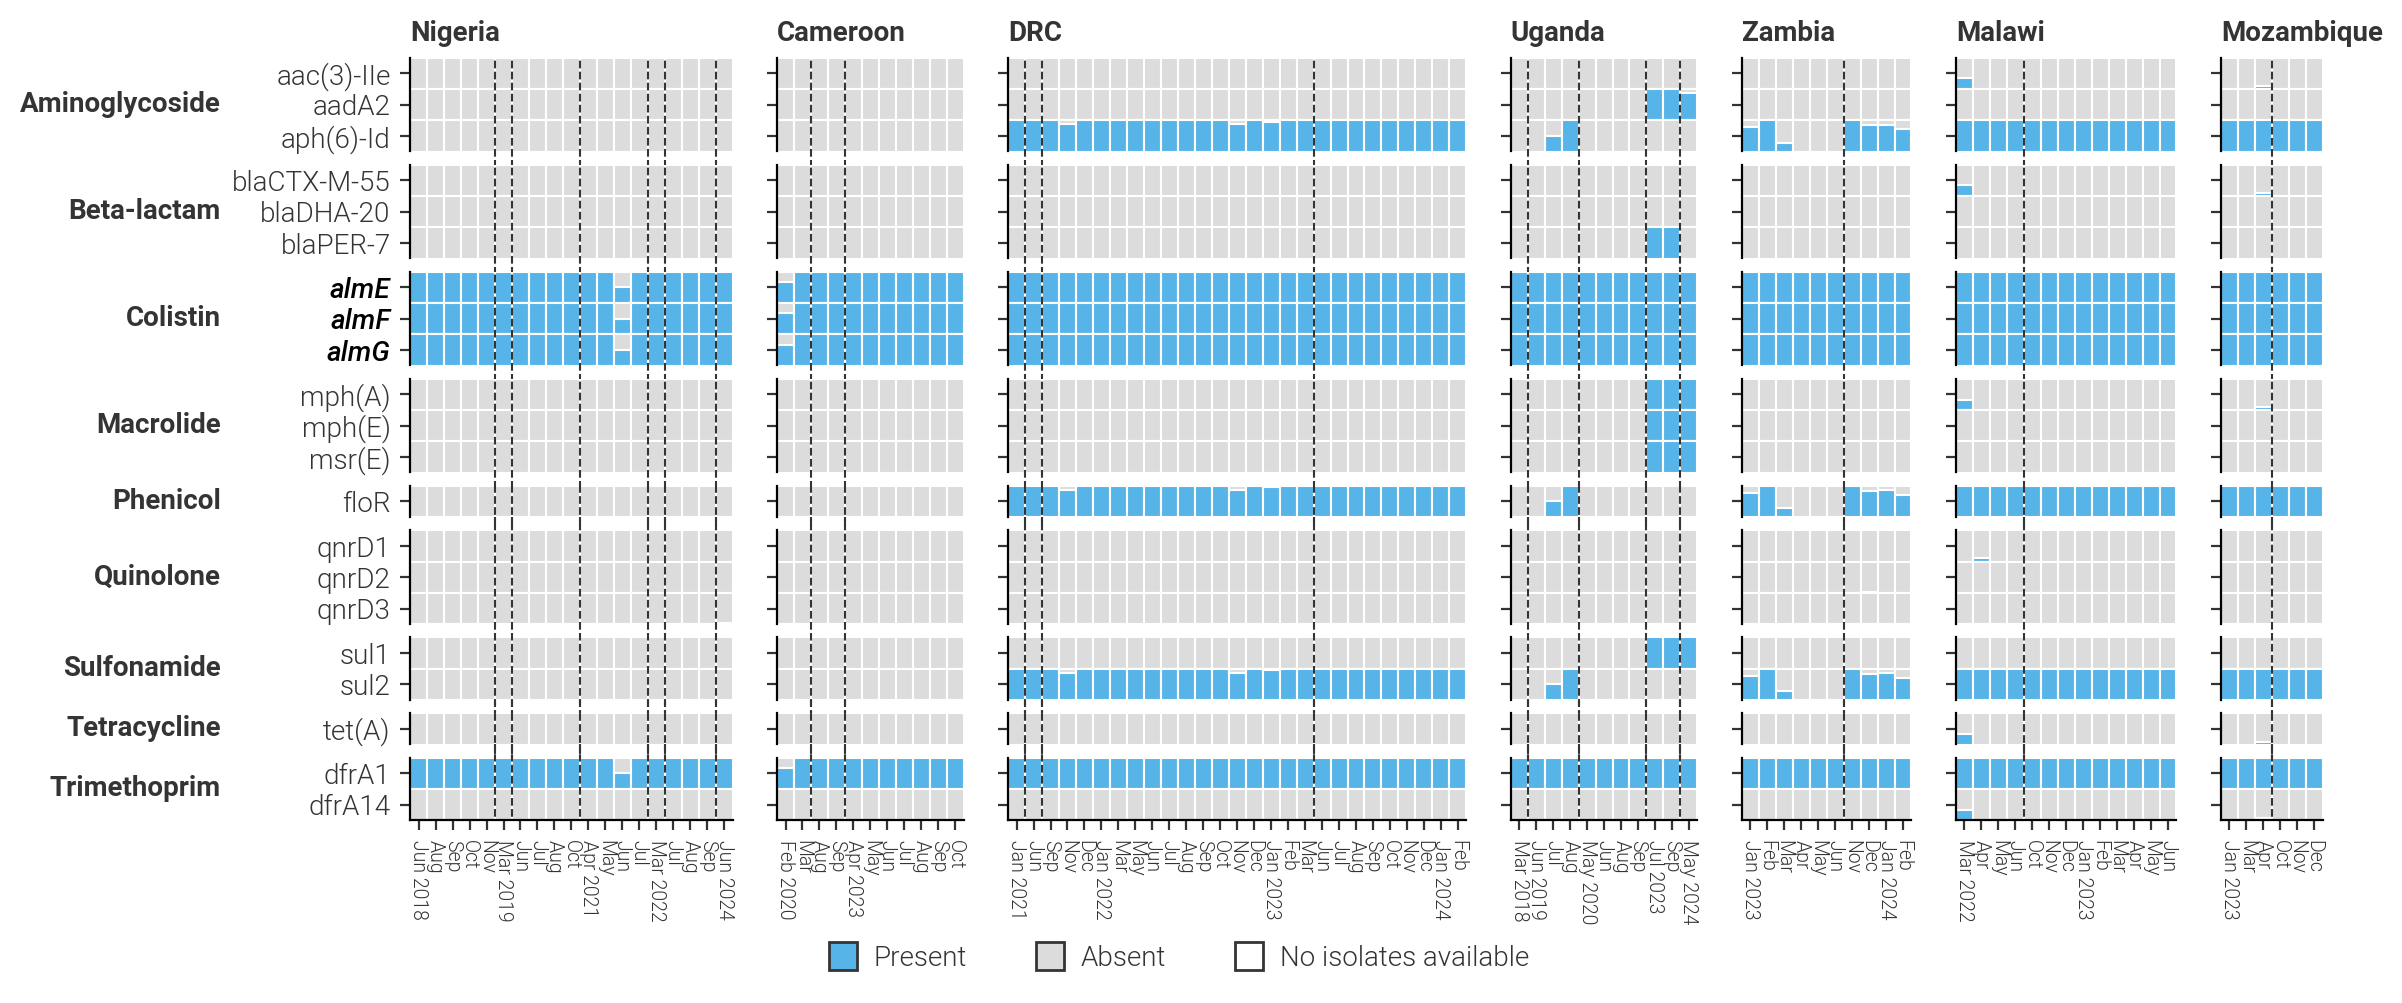

In [7]:
countries = ["Nigeria", "Cameroon", "Democratic Republic of the Congo", "Uganda", "Zambia", "Malawi", "Mozambique"]
class_order = gene_resistances["Class"].value_counts().sort_index()
classes = class_order.index

ref_genes = ["varG","almG","almF","almE","catB9"]

country_cols = [len( country_dates[country] ) for country in countries]

fig, axes = plt.subplots( dpi=200, figsize=(12,5), nrows=len( classes ), ncols=len( countries ), sharey="row", sharex="col", gridspec_kw={"height_ratios": class_order.to_list(), "width_ratios": country_cols} )

for ax_row, clas in zip( axes, classes ):
    for ax, country in zip( ax_row, countries):
        class_genes = gene_resistances.loc[gene_resistances["Class"]==clas,"#Allele"].to_list()
        date_order = country_dates[country]
        date_str = country_date_str[country]
        for yidx, gene in enumerate( class_genes ):
            for xidx, (date, line_type) in enumerate( date_order ):

                data = amr_long.loc[(amr_long["gene"]==gene)&(amr_long["country"]==country)&(amr_long["month"]==date)]
                ax.bar( x=[xidx], height=data["absent"], bottom=[yidx], width=1, color="gainsboro", edgecolor="white", linewidth=0.75 )
                ax.bar( x=[xidx], height=data["present"], bottom=data["absent"] + yidx, width=1, color="#56B4E9", edgecolor="white", linewidth=0.75 )
        
        for idx, (date, linetype) in enumerate( date_order ):
            if linetype == "line":
                ax.axvline( x=idx-0.5, ymin=-1, ymax=1, color=COLOR, linewidth=0.75, linestyle="dashed", clip_on=(clas=="TRIMETHOPRIM") )
        
        ax.set_yticks( [i + 0.5 for i in range( len( class_genes ) )], class_genes, fontsize=8, minor=False )
        ax.set_yticks( range( len( class_genes ) ), minor=True )
        ax.set_xticks( range( len( date_str ) ), date_str, fontsize=7, rotation=270 )
        ax.grid( which="major", axis="both", linewidth=0.75, color="#F1F1F1", zorder=-100 )

        for num, i in enumerate( ax.get_yticklabels() ):
            if i.get_text() in ref_genes:
                i.set_fontstyle( "italic" )
                i.set_fontweight( "medium" )
                i.set_color( "black" )

        ax.set_xlim( -0.5, len( date_str )-0.5 )
        ax.set_ylim( 0, len( class_genes )-0.01 )
        
        spines = ["left", "bottom"] if clas == "TRIMETHOPRIM" else ["left"]
        [ax.spines[j].set_visible( False ) for j in ax.spines if j not in spines]
        
        ax.tick_params( axis="x", which="both", direction="out", labelbottom=True, zorder=200 )
        ax.tick_params( axis="y", which="major", direction="out", labelleft=True, labelsize=10 )
        ax.tick_params( axis="y", which="minor", labelleft=False, length=0 )

        if clas != "TRIMETHOPRIM":
            ax.tick_params( axis="x", which="both", direction="inout", labelbottom=False, length=0 )
        
        ax.invert_yaxis()
        #ax.set_ylabel( clas, fontsize=8, fontweight="bold", rotation=0, ha="left", va="center", labelpad=75 )
        ax.set_ylabel( clas.capitalize(), fontsize=10, fontweight="bold", rotation=0, ha="right", va="center" )
        ax.label_outer()
        ax.set_axisbelow(True)

fig.align_ylabels(axes[:,0] )

for ax, country in zip( axes[0,:], countries ):
    ax.set_title( country.replace( "Democratic Republic of the Congo", "DRC" ), fontsize=10, fontweight="bold", loc="left" )

legend1 = [
    Line2D([0], [0], linestyle='none', marker='s', color="#56B4E9", markeredgecolor=COLOR, markeredgewidth=1, label="Present", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='s', color="gainsboro", markeredgecolor=COLOR, markeredgewidth=1, label="Absent", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='s', color="white", markeredgecolor=COLOR, markeredgewidth=1, label="No isolates available", markersize=10 )
]

legend1 = fig.legend( handles=legend1, loc="lower center", ncols=3, frameon=False, fontsize=10, handletextpad=0.1, bbox_to_anchor=[0,-0.025,1,1] ) 

plt.tight_layout( w_pad=0.75, h_pad=0.25)
fig.savefig( "plots/figureS4-AMR-resistance-over-time.pdf", bbox_extra_artists=(legend1,), bbox_inches='tight' )
fig.savefig( "plots/figureS4-AMR-resistance-over-time.png", bbox_extra_artists=(legend1,), bbox_inches='tight' )
plt.show()

We repeat the steps performed above, but stratifying by year rather than month. This generates figure 2C.

In [8]:
amr_year = amr_core_genes.melt( id_vars=["taxa", "country", "year"], value_vars=amr_columns, var_name="gene", value_name="present" )
amr_year = amr_year.groupby( ["country", "year", "gene"] ).agg( total=("present", "count"), present=("present", "sum")).reset_index()
amr_year["absent"] = amr_year["total"] - amr_year["present"]
amr_year["absent"] /= amr_year["total"]
amr_year["present"] /= amr_year["total"]
amr_year["gene"] = amr_year["gene"].str.replace( "core_gene_", "" )
amr_year = amr_year.loc[~amr_year["gene"].isin(["dfrA14","blaDHA-20"])]     # Drop sporadic genes.

gene_resistances = resistances.loc[resistances["#Allele"].isin( amr_year["gene"].unique() )].groupby( "#Allele").last().reset_index()
gene_resistances = gene_resistances[["#Allele", "Gene family", "Class", "Subclass"]]
gene_resistances["Class"] = gene_resistances["Class"].apply( lambda x: x.split( "/" )[0] )
gene_resistances = gene_resistances.sort_values( ["Class", "#Allele"])
gene_order = gene_resistances["#Allele"].to_list()
gene_names = gene_resistances["Gene family"].to_list()
#gene_resistances

amr_year.head()

,country,year,gene,total,present,absent
0,Cameroon,2020,aac(3)-IIe,15,0.0,1.0
1,Cameroon,2020,aadA2,15,0.0,1.0
2,Cameroon,2020,almE,15,0.933333,0.066667
3,Cameroon,2020,almF,15,0.933333,0.066667
4,Cameroon,2020,almG,15,0.933333,0.066667


In [9]:
country_dates = dict()
country_date_str = dict()
date_format = "%Y"
secondary_format = "%Y"

for country, entry in amr_year.loc[amr_long["gene"]=="aac(3)-IIe"].groupby( "country" ):
    prior_date = None
    date_order = list()
    date_str = list()
    for date in entry["year"]:
        if prior_date is None:
            prior_date = date
        duration = date - prior_date
        date_order.append( (date, "line" if duration >= 1.5 else "normal" ) )
        date_str.append( date )
        prior_date = date
    country_dates[country] = date_order
    country_date_str[country] = date_str

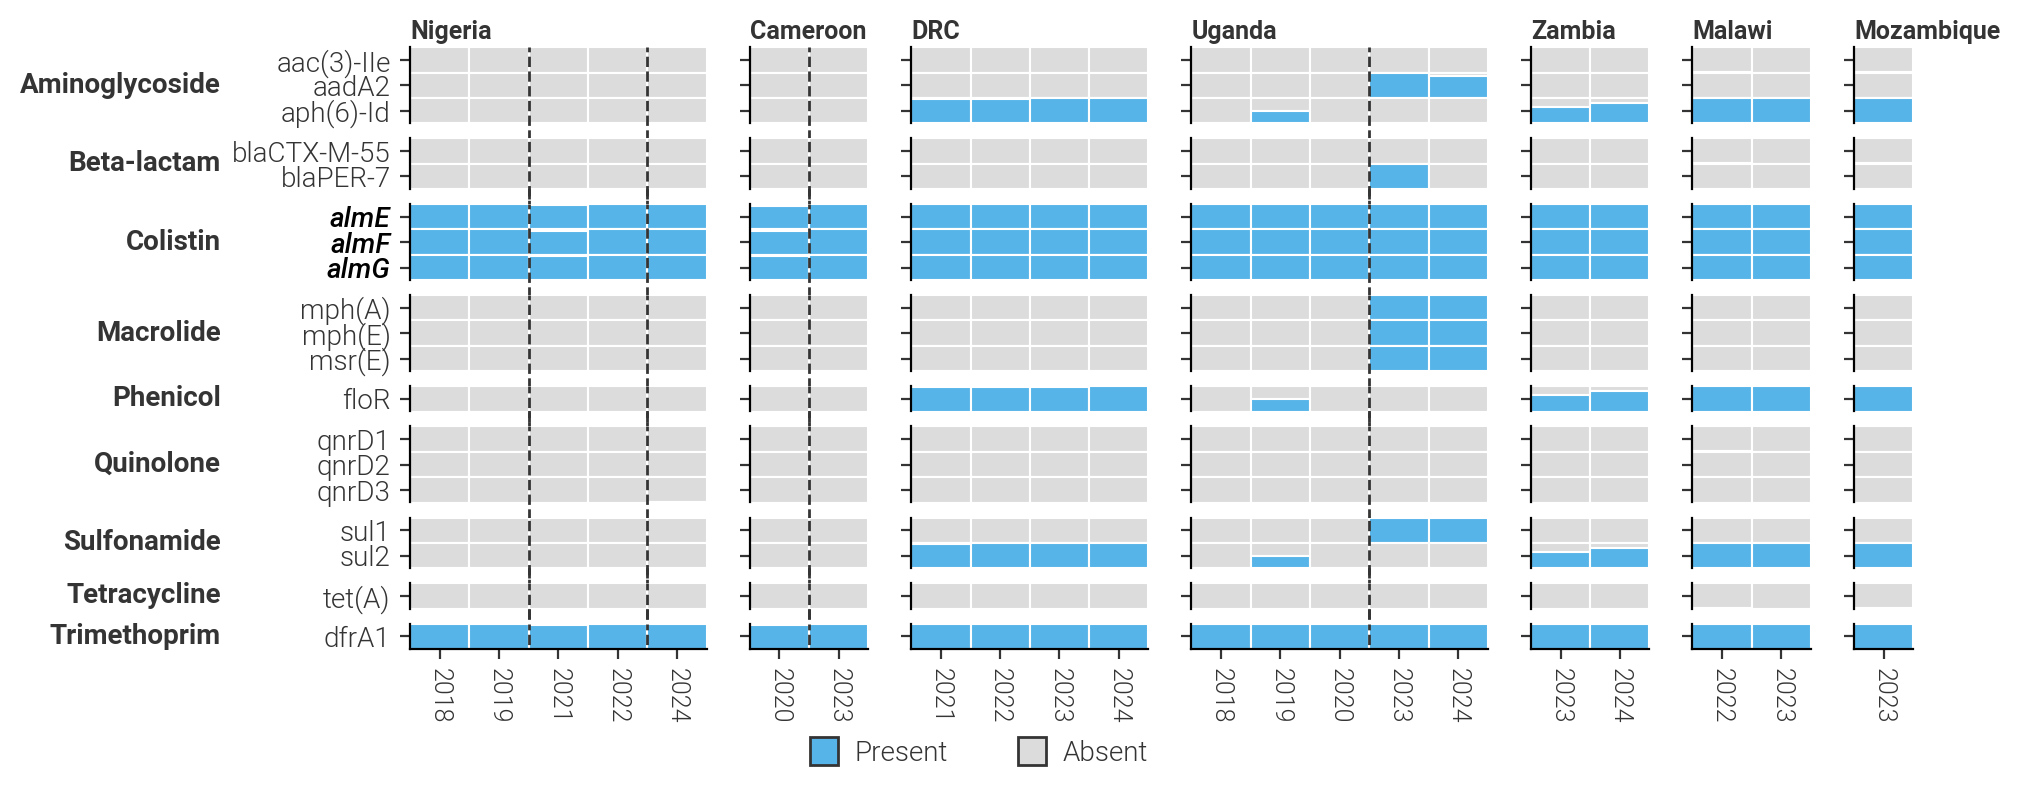

In [10]:
countries = ["Nigeria", "Cameroon", "Democratic Republic of the Congo", "Uganda", "Zambia", "Malawi", "Mozambique"]
class_order = gene_resistances["Class"].value_counts().sort_index()
classes = class_order.index

country_cols = [len( country_dates[country] ) for country in countries]

fig, axes = plt.subplots( dpi=200, figsize=(10,4), nrows=len( classes ), ncols=len( countries ), sharey="row", sharex="col", gridspec_kw={"height_ratios": class_order.to_list(), "width_ratios": country_cols} )

for ax_row, clas in zip( axes, classes ):
    for ax, country in zip( ax_row, countries):
        class_genes = gene_resistances.loc[gene_resistances["Class"]==clas,"#Allele"].to_list()
        date_order = country_dates[country]
        date_str = country_date_str[country]
        for yidx, gene in enumerate( class_genes ):
            for xidx, (date, line_type) in enumerate( date_order ):

                data = amr_year.loc[(amr_year["gene"]==gene)&(amr_year["country"]==country)&(amr_year["year"]==date)]
                ax.bar( x=[xidx], height=data["absent"], bottom=[yidx], width=1, color="gainsboro", edgecolor="white", linewidth=0.75 )
                ax.bar( x=[xidx], height=data["present"], bottom=data["absent"] + yidx, width=1, color="#56B4E9", edgecolor="white", linewidth=0.75 )
        
        for idx, (date, linetype) in enumerate( date_order ):
            if linetype == "line":
                ax.axvline( x=idx-0.5, ymin=-1, ymax=1, color=COLOR, linewidth=1, linestyle="dashed", clip_on=(clas=="TRIMETHOPRIM") )
        
        ax.set_yticks( [i + 0.5 for i in range( len( class_genes ) )], class_genes, fontsize=8, minor=False )
        ax.set_yticks( range( len( class_genes ) ), minor=True )
        ax.set_xticks( range( len( date_str ) ), date_str, fontsize=9, rotation=270 )
        ax.grid( which="major", axis="both", linewidth=0.75, color="#F1F1F1", zorder=-100 )

        for num, i in enumerate( ax.get_yticklabels() ):
            if i.get_text() in ref_genes:
                i.set_fontstyle( "italic" )
                i.set_fontweight( "medium" )
                i.set_color( "black" )

        ax.set_xlim( -0.5, len( date_str )-0.5 )
        ax.set_ylim( 0, len( class_genes )-0.01 )
        
        spines = ["left", "bottom"] if clas == "TRIMETHOPRIM" else ["left"]
        [ax.spines[j].set_visible( False ) for j in ax.spines if j not in spines]
        
        ax.tick_params( axis="x", which="both", direction="out", labelbottom=True, zorder=200 )
        ax.tick_params( axis="y", which="major", direction="out", labelleft=True, labelsize=10 )
        ax.tick_params( axis="y", which="minor", labelleft=False, length=0 )

        if clas != "TRIMETHOPRIM":
            ax.tick_params( axis="x", which="both", direction="inout", labelbottom=False, length=0 )
        
        ax.invert_yaxis()
        #ax.set_ylabel( clas, fontsize=8, fontweight="bold", rotation=0, ha="left", va="center", labelpad=75 )
        ax.set_ylabel( clas.capitalize(), fontsize=10, fontweight="bold", rotation=0, ha="right", va="center" )
        ax.label_outer()
        ax.set_axisbelow(True)

fig.align_ylabels(axes[:,0] )

for ax, country in zip( axes[0,:], countries ):
    ax.set_title( country.replace( "Democratic Republic of the Congo", "DRC" ), fontsize=9, fontweight="bold", loc="left", pad=3 )

legend1 = [
    Line2D([0], [0], linestyle='none', marker='s', color="#56B4E9", markeredgecolor=COLOR, markeredgewidth=1, label="Present", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='s', color="gainsboro", markeredgecolor=COLOR, markeredgewidth=1, label="Absent", markersize=10 )
]

legend1 = fig.legend( handles=legend1, loc="lower center", ncols=3, frameon=False, fontsize=10, handletextpad=0.1, bbox_to_anchor=[0,-0.025,1,1] ) 

plt.tight_layout( w_pad=0.75, h_pad=0.25)
plt.savefig( "plots/figure2-AMR-resistance-per-year.pdf", bbox_extra_artists=(legend1,), bbox_inches='tight' )
plt.show()